In [378]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from scipy.fftpack import fft, fftshift, ifft
from scipy import signal
from scipy.ndimage import shift

In [353]:
# 简单将上述代码封装成了一个类
# fsamp 采样频率，fm 最大多普勒平移, T 总时长， E deta^2, N0 波到达个数 
class jack_hz:
    def __init__(self, fsamp, fm, T, E, N0, x=np.linspace(-1, 5, 500)):
        self.fsamp = fsamp
        self.fm = fm
        self.T = T
        self.E = E
        self.N0 = N0
        self.x = x
        self.ht = self.get_ht()
        self.Tc = 9/16/np.pi/fm
        self.pdf = self.get_pdf()

    # 得到包络ht
    def get_ht(self):
        # 随机相位
        phase = (np.random.randn(1, self.N0) * 2 * math.pi)[0]

        #N为夹角，必定为正，入射波和平面夹角必定为正
        N = (self.N0*2+1)*2
        t = np.arange(0, self.T, 1/self.fsamp)
        beta_n = np.linspace(1, self.N0, self.N0) * math.pi/(self.N0+1)

        wn = 2 * math.pi * self.fm * np.cos(2*math.pi*np.linspace(1, self.N0, self.N0)/N)
        wd = 2 * math.pi * self.fm

        Ts = np.zeros(t.shape[0])
        Tc = np.zeros(t.shape[0])
        for i in range(self.N0):
            Tc = Tc+math.cos(beta_n[i])*np.cos(wn[i]*t+phase[i])
            Ts = Ts+math.sin(beta_n[i])*np.cos(wn[i]*t+phase[i])

        Tc = Tc*2 + math.sqrt(2)*np.cos(wd*t)
        Ts = Ts*2
        ht = self.E*(Tc+Ts*1j)/math.sqrt(2*self.N0+1)

        return ht

    def get_pdf(self):
        kernel = stat.gaussian_kde(np.abs(self.ht))
        a = kernel(self.x)
        return a

In [446]:
def Delay_r(delay, st, fsamp, jack):
    N = jack.shape[0]
    stt_real = np.zeros((N, st.shape[0]))
    stt_vir = np.zeros((N, st.shape[0]))
    for i in range(N):
        # rand = np.random.randn(1)
        stt_real[i] = shift(st.real, int(delay*fsamp*i/N),cval=0)/(2**(-i))/500
        stt_vir[i] = shift(st.imag, int(delay*fsamp*i/N),cval=0)/(2**(-i))/500
        # p[i] = (2**(-i))**2/2500
    yt = np.zeros(st.shape[0])
    p = np.zeros(N)
    for i in range(N):
        temp = (stt_real[i]+stt_vir[i]*1j)*jack[i]
        p[i] = np.sum(temp.real**2 + temp.imag**2)/fsamp
        yt = yt + temp
        # p[i] = np.sum(stt_real[i]**2 + stt_vir[i]**2)/fsamp
    de = np.linspace(delay/N, delay, N)
    tao = np.sqrt(np.sum(p*(de**2))/np.sum(p)-(np.sum(p*de)/np.sum(p))**2)
    print('附加时延:'+str(tao)+'  '+'Bc:'+str(1/50/tao))
    return yt

# 选择和平坦

In [447]:
# 参数设置,载波频率
# fc = 2*10**9
# 采样频率
fsamp = 10**4
fm = 5
# 延时
E = 1
T = 1
t = np.arange(0, T, 1/fsamp)
hz = np.arange(-np.floor(fsamp*T/2), np.floor(fsamp*T/2), 1)

In [448]:
N = 10
jack = np.zeros((N, t.shape[0]), dtype=complex)
for i in range(N):
    jack[i] = jack_hz(fsamp, fm, T, E, 200).ht

In [449]:
p1 = np.zeros(t.shape[0])
for i in range(3000, 4000):
    p1 = np.sin(2*np.pi*i*t) + p1
p1 = p1/5000

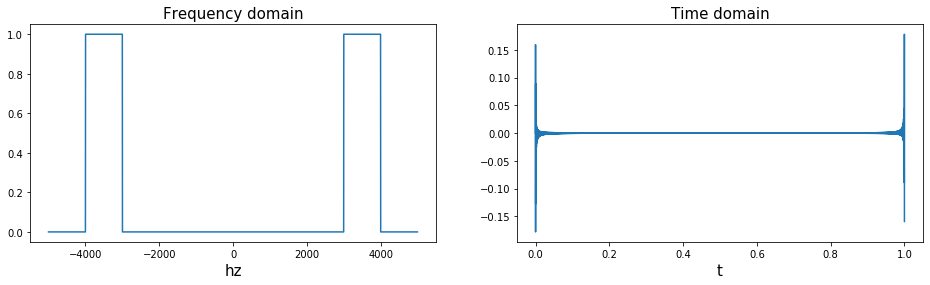

In [450]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax1.plot(hz, abs(fftshift(fft(p1))))
ax1.set_xlabel('hz', fontsize=15)
ax1.set_title('Frequency domain', fontsize=15)
ax2 = fig.add_subplot(122)
ax2.plot(t, p1)
ax2.set_xlabel('t', fontsize=15)
ax2.set_title('Time domain', fontsize=15)
fig.savefig('Input signal.svg',bbox_inches="tight")

**慢衰落**

In [451]:
y1 = Delay_r(0.001, p1, fsamp, jack)

附加时延:6.456430789911197e-05  Bc:309.7686732931754


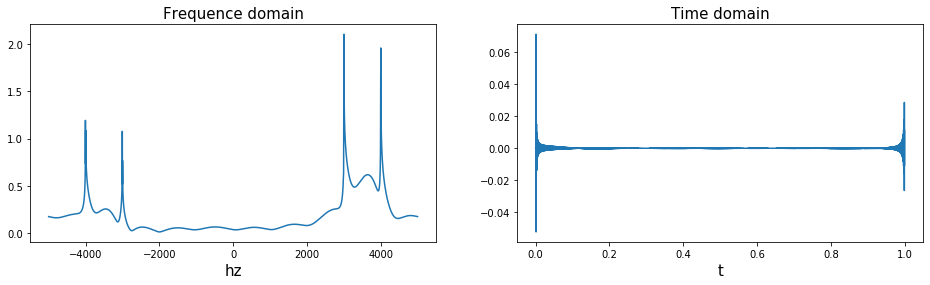

In [452]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax1.plot(hz, abs(fftshift(fft(y1))))
ax1.set_xlabel('hz', fontsize=15)
ax1.set_title('Frequence domain', fontsize=15)
ax2 = fig.add_subplot(122)
ax2.plot(t, np.real(y1))
ax2.set_xlabel('t', fontsize=15)
ax2.set_title('Time domain', fontsize=15)
fig.savefig('Output signal slow.svg',bbox_inches="tight")

**快衰弱**

In [453]:
y2 = Delay_r(0.05, p1, fsamp, jack)

附加时延:0.0019295287614911982  Bc:10.36522512602683


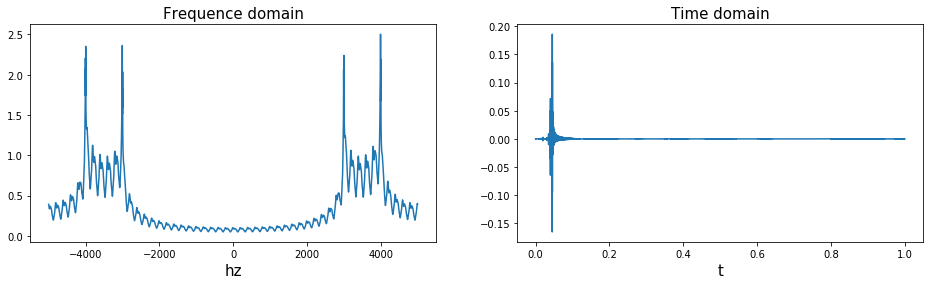

In [454]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax1.plot(hz, abs(fftshift(fft(y2))))
ax1.set_xlabel('hz', fontsize=15)
ax1.set_title('Frequence domain', fontsize=15)
ax2 = fig.add_subplot(122)
ax2.plot(t, np.real(y2))
ax2.set_xlabel('t', fontsize=15)
ax2.set_title('Time domain', fontsize=15)
fig.savefig('Output signal quick.svg',bbox_inches="tight")